In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [3]:
x_train = train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

In [4]:
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels train 0.06
% pos labels test 0.06


### One Hot Encoding Cataegorical Data

In [6]:
# ONE HOT CODE data for training

# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

one_hot_encoded_array = encoder.fit_transform(x_train[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_train_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_train = x_train.merge(x_train_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_train = x_train.drop(labels = cat_col, axis = 'columns') # drop original variables

In [7]:
# Create dummy variables
one_hot_encoded_array = encoder.transform(x_test[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_test_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_test = x_test.merge(x_test_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_test = x_test.drop(labels = cat_col, axis = 'columns') # drop original variables

In [8]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 1183
Number records in testset 507
% pos labels train 0.06
% pos labels test 0.06


### Defining Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Pipeline for logist Classifier
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

# Decision Tree Classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = {'max_features':['sqrt','log2',None],
                  'min_samples_leaf': [2,5,10,15,20], 
                  'class_weight' :['balanced'], 
                  'random_state': [1234]}  


classifier_DTC = GridSearchCV(DTC, parameter_dist, n_jobs = -1, scoring = 'average_precision', cv = 10 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [13]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 5, 'random_state': 1234}

 Model Best CV score: 
0.4107587444020242

 Model Balanced Accuracy: 
0.7272591708917387

 Confusion Matrix : 
[[423  56]
 [ 12  16]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       479
           1       0.22      0.57      0.32        28

    accuracy                           0.87       507
   macro avg       0.60      0.73      0.62       507
weighted avg       0.93      0.87      0.89       507


 AUC-ROC: 
0.7602147330748584

 PR-ROC: 
0.6211701591256247


In [14]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    #from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [15]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [16]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.760665,0.620529
std,0.053357,0.089799
min,0.541789,0.171089
2.5%,0.655262,0.435569
50%,0.761035,0.623033
97.5%,0.864053,0.787310
max,0.949515,0.909311


# Random Forest Classifier

In [30]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state=42)
parameter_dist = {'n_estimators': [100,200,300,500,1000], 
                  'max_features':['sqrt','log2'],
                  'min_samples_leaf': [2,3,4,5], 
                  'class_weight' :['balanced'] 
} 


classifier_RFR = GridSearchCV(RFC, parameter_dist, n_jobs = -1,cv=10, scoring = 'average_precision', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)


C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
y_RFR = classifier_RFR.predict(x_test)
classifier = classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [32]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))
print(metrics.average_precision_score(y_test, results_RFR['pred_prob']))

{'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}

 Model Best CV score: 
0.5113078317758685

 Confusion Matrix : 
[[472   7]
 [ 13  15]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       479
           1       0.68      0.54      0.60        28

    accuracy                           0.96       507
   macro avg       0.83      0.76      0.79       507
weighted avg       0.96      0.96      0.96       507


 AUC-ROC: 
0.8377572323292575

 PR-ROC: 
0.5835970445758616
0.5871213923195333


In [20]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [21]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.849370,0.572524
std,0.040627,0.094039
min,0.688472,0.168504
2.5%,0.766339,0.377023
50%,0.850704,0.576186
97.5%,0.923673,0.747359
max,0.977557,0.897072


# Prepare data for Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__class_weight':['balanced'],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }



clf = Pipeline(steps=[('preprocessor', preprocessor),
                      #('pca',PCA()),
                      ('classifier', LogisticRegression(random_state = 42))])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring= 'average_precision', cv = 10)

In [23]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [25]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))
print(metrics.average_precision_score(y_test, results_logit['pred_prob']))

{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

 Model Best CV score: 
0.40036574549309334

 Model Balanced Accuracy: 
0.7141365940948404

 Confusion Matrix : 
[[342 137]
 [  8  20]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       479
           1       0.13      0.71      0.22        28

    accuracy                           0.71       507
   macro avg       0.55      0.71      0.52       507
weighted avg       0.93      0.71      0.79       507


 AUC-ROC: 
0.8234416940053684

 PR-ROC: 
0.39913187465712535
0.4058715327377367


In [26]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [27]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.824028,0.400876
std,0.042097,0.093496
min,0.619588,0.082870
2.5%,0.734108,0.213122
50%,0.825753,0.402937
97.5%,0.901818,0.583007
max,0.969783,0.759887


# Compare Classifiers

C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


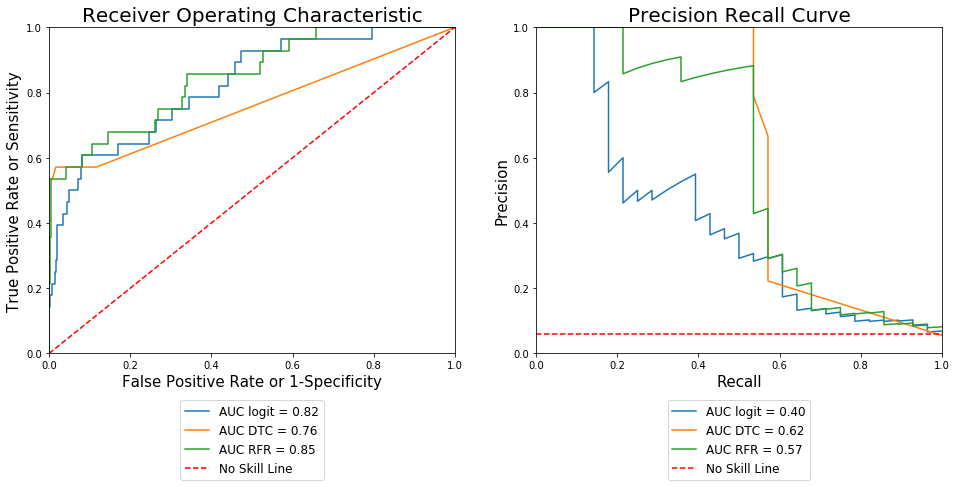

In [29]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [80]:
output_path = 'output/models'

In [81]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [82]:
# Export Decision Tree Classifier with Pipeline
from joblib import dump
dump(classifier_DTC, output_path+'/DTC.joblib')

['output/models/DTC.joblib']

In [83]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/RFR.joblib')

['output/models/RFR.joblib']

In [84]:
# Export LOgistic Classifer with Pipeline
from joblib import dump
dump(classifier_logit, output_path+'/Logit.joblib')

['output/models/Logit.joblib']

In [85]:
from joblib import dump
dump(encoder, output_path+'/OHE.joblib')

['output/models/OHE.joblib']